# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

(I strongly recommend you to try this notebook on the Udacity workspace first before running it locally on your desktop/laptop, as performance might suffer in different environments)

In [50]:
import math
import random
import time
from collections import deque,namedtuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import progressbar as pb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from apex import amp

%matplotlib inline

In [51]:
# check which device is being used.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using device: ",device)

using device:  cuda:0


In [3]:
# env = gym.make('CartPole-v0')
env = gym.make('Pendulum-v0')
env.seed(2)
action_size = 1
state_size = 3
print(env.action_space)
print(env.observation_space)


Box(-2.0, 2.0, (1,), float32)
Box(-8.0, 8.0, (3,), float32)


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel

In [4]:
state = env.reset()
while True:
    env.render()
    action = np.array([np.random.rand(1,) * 4 - 2])
    state, reward, done, _ = env.step(action)
    if done:
        break
time.sleep(2)

env.close()

# Replay Buffer

In [52]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size, seed=123):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", "state, action, reward, next_state, done")
        np.random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        e =self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
    def sample(self):
        n = min(self.batch_size, len(self.memory))
        experiences = random.sample(self.memory, k=n)
        
        states = torch.from_numpy(np.array([e.state for e in experiences])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences])).float().to(device)
        
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)

In [53]:
buffer = ReplayBuffer(100, 20, 123)
buffer.add((1, 2, 3), 1, 1, (3, 4, 5), False)
buffer.add((2, 3, 4), 0, 1, (5, 6, 7), False)
buffer.add((5, 6, 7), 0, 0, (7, 8, 9), False)
a = buffer.sample()
a


(tensor([[2., 3., 4.],
         [5., 6., 7.],
         [1., 2., 3.]], device='cuda:0'),
 tensor([[0.],
         [0.],
         [1.]], device='cuda:0'),
 tensor([[1.],
         [0.],
         [1.]], device='cuda:0'),
 tensor([[5., 6., 7.],
         [7., 8., 9.],
         [3., 4., 5.]], device='cuda:0'),
 tensor([[0.],
         [0.],
         [0.]], device='cuda:0'))

# Policy



In [54]:
class Actor(nn.Module):

    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        
        num_hidden1 = 400
        num_hidden2 = 300

        self.fc1 = nn.Linear(state_size, num_hidden1)
        self.fc2 = nn.Linear(num_hidden1, num_hidden2)
        self.fc3 = nn.Linear(num_hidden2, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))


In [7]:
class Critic(nn.Module):

    def __init__(self, state_size, action_size):
        super(Critic, self).__init__()
        
        num_hidden1 = 400
        num_hidden2 = 300

        self.fc1 = nn.Linear(state_size, num_hidden1)
        self.fc2 = nn.Linear(num_hidden1 + action_size, num_hidden2)
        self.fc3 = nn.Linear(num_hidden2, 1)

    def forward(self, state, action):
        xs = F.relu(self.fc1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x) 


In [8]:
state = torch.rand(4, 3)
action = torch.rand(4, 1)
print(state)
print(action)
torch.cat((state, action), dim=1)

tensor([[0.9886, 0.9875, 0.9850],
        [0.4579, 0.0218, 0.2663],
        [0.3686, 0.9066, 0.8005],
        [0.2967, 0.4766, 0.3484]])
tensor([[0.3677],
        [0.2084],
        [0.7682],
        [0.2398]])


tensor([[0.9886, 0.9875, 0.9850, 0.3677],
        [0.4579, 0.0218, 0.2663, 0.2084],
        [0.3686, 0.9066, 0.8005, 0.7682],
        [0.2967, 0.4766, 0.3484, 0.2398]])

# Function Definitions



# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [55]:
class DDPGAgentParams():
    def __init__(
        self, 
        buffer_size=int(1e5), 
        batch_size=128, 
        actor_lr = 1e-4, 
        critic_lr = 1e-3, 
        gamma = .99, 
        tau = 1e-3):
        
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.gamma = gamma
        self.tau = tau



class DDPGAgent():
    def __init__(self, state_size, action_size, params, device="cpu"):
        self.params = params
        self.device = device
        
        self.actor_local = Actor(state_size, action_size).to(device)
        self.actor_target = Actor(state_size, action_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=params.actor_lr)

        self.critic_local = Critic(state_size, action_size).to(device)
        self.critic_target = Critic(state_size, action_size).to(device)
        self.critic_loss = nn.MSELoss()
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=params.critic_lr)
        
        self.memory = ReplayBuffer(params.buffer_size, params.batch_size)
    
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        if len(self.memory) > self.params.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences)
            

    def to_float_tensor(self, ndarray):
        return torch.from_numpy(ndarray).float().to(self.device)
    
    def to_numpy(self, tensor):
        return tensor.detach().cpu().numpy()
    
    def act(self, state):
        state_tensor = self.to_float_tensor(state)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.to_numpy(self.actor_local(state_tensor))
        
        self.actor_local.train()
        action = np.clip(action, -1, 1)
        return action
        
    
    def learn(self, experiences):
        states_tensor, actions_tensor, rewards_tensor, next_states_tensor, dones_tensor = experiences
        
        # Q Target (with target network)
        actions_next_tensor = self.actor_target(next_states_tensor)
        Q_targets_next = self.critic_target(next_states_tensor, actions_next_tensor)
        Q_targets = rewards_tensor + (gamma * Q_targets_next * (1 - dones_tensor))

        # Q Expected (with local network)
        Q_expected = self.critic_local(states_tensor, actions_tensor)
        critic_loss = self.critic_loss(Q_expected, Q_targets)
        
        # Optimize Critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Actor loss
        actions_tensor = self.actor_local(states_tensor)
        actor_loss = -self.critic_local(states_tensor, actions_tensor).mean()

        # Optimize Actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Soft update
        self.soft_update(self.critic_local, self.critic_target, self.params.tau)
        self.soft_update(self.actor_local, self.actor_target, self.params.tau)             
            
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


Episode 100	Average Score: -1171.71
Episode 200	Average Score: -509.781
Episode 300	Average Score: -265.60


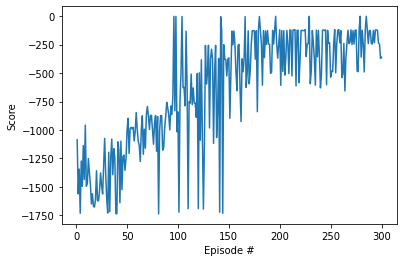

In [56]:
params = DDPGAgentParams()
agent = DDPGAgent(3, 1, params, device=device)


episode = 300

scores_deque = deque(maxlen=100)
scores = []
for i in range(1, episode+1):
    state = env.reset()
    score = 0
    while True:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break 
            
    scores_deque.append(score)
    scores.append(score)
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(scores_deque)), end="")
    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
    if i % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(scores_deque)))


fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [58]:
# Print best agent
state = env.reset()
for t in range(200):
    action = agent.act(state)

    env.render()
    print("\r{} {}".format(t, action), end="")
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()

199 [0.29963252]]

# Function version

In [9]:
buffer_size = int(1e5)
batch_size = 128
# batch_size = 2

gamma = .99
actor_lr = 1e-4
critic_lr = 1e-3
tau = 1e-3


In [11]:
def soft_update(local_model, target_model, tau):
    """Soft update model parameters.
    θ_target = τ*θ_local + (1 - τ)*θ_target

    Params
    ======
        local_model: PyTorch model (weights will be copied from)
        target_model: PyTorch model (weights will be copied to)
        tau (float): interpolation parameter 
    """
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
        target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


In [32]:

actor_local = Actor(state_size, action_size).to(device)
actor_target = Actor(state_size, action_size).to(device)
actor_optimizer = optim.Adam(actor_local.parameters(), lr=actor_lr)

critic_local = Critic(state_size, action_size).to(device)
critic_target = Critic(state_size, action_size).to(device)
critic_optimizer = optim.Adam(critic_local.parameters(), lr=critic_lr)

episode = 1000
memory = ReplayBuffer(buffer_size, batch_size)


# keep track of progress
scores_deque = deque(maxlen=100)
scores = []

policy_loss_fn = nn.MSELoss()
critic_loss_fn = nn.MSELoss()

state = env.reset()


RIGHT = 0
LEFT = 1
for i in range(episode):
    state = env.reset()
    score = 0

    while True:
        # Get action
        state_tensor = torch.from_numpy(state).float().to(device)
        actor_local.eval()
        with torch.no_grad():
            action = actor_local(state_tensor).detach().cpu().numpy()
        
        actor_local.train()
        action = np.clip(action, -1, 1)

        # Step
        next_state, reward, done, _ = env.step(action)
        memory.add(state, action, reward, next_state, done)

        if len(memory) > batch_size:
            experiences = memory.sample()
            states_tensor, actions_tensor, rewards_tensor, next_states_tensor, dones_tensor = experiences

            # ---------------------------- update critic ---------------------------- #
            # Get predicted next-state actions and Q values from target models
            actions_next_tensor = actor_target(next_states_tensor)
            Q_targets_next = critic_target(next_states_tensor, actions_next_tensor)
            # Compute Q targets for current states (y_i)
            Q_targets = rewards_tensor + (gamma * Q_targets_next * (1 - dones_tensor))
            # Compute critic loss
            Q_expected = critic_local(states_tensor, actions_tensor)
            critic_loss = F.mse_loss(Q_expected, Q_targets)
            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()

            # ---------------------------- update actor ---------------------------- #
            # Compute actor loss
            actions_pred_tensor = actor_local(states_tensor)
            actor_loss = -critic_local(states_tensor, actions_pred_tensor).mean()
            # Minimize the loss
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            # ----------------------- update target networks ----------------------- #
            soft_update(critic_local, critic_target, tau)
            soft_update(actor_local, actor_target, tau)             
            
        score += reward
        state = next_state

        if done:
            break

    scores_deque.append(score)
    scores.append(score)

    # display some progress every 20 iterations
    if i % 20 == 0:
        print("\rEpisode: {0:d}, score: {1:f}".format(i + 1, np.mean(scores_deque)), end="")
        torch.save(actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(critic_local.state_dict(), 'checkpoint_critic.pth')


NameError: name 'self' is not defined

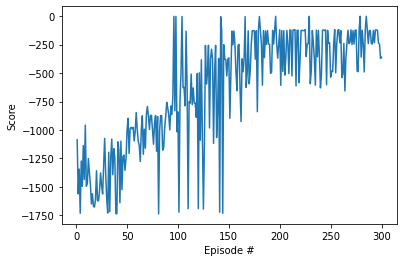

In [57]:
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [27]:
actor_local.load_state_dict(torch.load('checkpoint_actor1.pth'))
critic_local.load_state_dict(torch.load('checkpoint_critic1.pth'))


<All keys matched successfully>

In [39]:
# Print best agent
state = env.reset()
for t in range(200):
    state_tensor = torch.from_numpy(state).float().to(device)
    actor_local.eval()
    with torch.no_grad():
        action = actor_local(state_tensor).detach().cpu().numpy()
    action = np.clip(action, -1, 1)

    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()